# [IAFlash](https://entrepreneur-interet-general.etalab.gouv.fr/defis/2019/iaflash.html) simple exploration

## Exemple of using transfer learning

We will give a try to transfer learning, using `Keras`.  
Specifically, we will reuse model `MobileNet` from Keras [model zoo](https://keras.io/applications/), and perform standard data augmentation using [`keras.preprocessing.image.ImageDataGenerator`](https://keras.io/preprocessing/image/) (see e.g. [here](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/) for use examples).

### Imports

In [1]:
import os
HOME = os.path.expanduser('~/')
HOST = os.uname()[1]
if HOST == 'Arthurs-MacBook-Pro.local':
    os.chdir(os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/'))    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))
    
import numpy as np
import re
import time
import pickle
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, \
                         Flatten, Dense, GlobalMaxPooling2D, \
                         AveragePooling2D, GlobalAveragePooling2D, \
                         MaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16

from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

/Users/arthur/anaconda3/envs/tree/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Variables

In [5]:
# data
if HOST == 'Arthurs-MacBook-Pro.local':
#     pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/Patches/edge128bwFalseresampleFilter0') # (small) MobileNet
#     pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/Patches/edge128bwTrueresampleFilter0') # dummy model
    pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/Patches/edge299bwFalseresampleFilter0') # InceptionV3 / VGG
    pathToIntellDir = os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/IAFlash/Intelligence/')
else:
    raise ValueError('unknown host: {}'.format(HOST))
data_format = 'channels_last'
nbClass = 196

# image processing
edge = int(re.findall('edge([0-9]*)',pathToDataDir)[0])
if 'bwTrue' in pathToDataDir:
    mode = 'grayscale'
elif 'bwFalse' in pathToDataDir:
    mode = 'rgb'
else:
    raise ValueError('color mode not undestood from data directory name')
    
# model compilation params
loss = 'categorical_crossentropy'
#optim = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#optim = Adamax()
optim = 'adam'
metric = ['accuracy']

# model training params
epochs = 10
earlystop = EarlyStopping(monitor='val_acc',
                          min_delta=0,
                          patience=20,
                          verbose=1)
checkpoint = ModelCheckpoint(os.path.join(pathToIntellDir, 'model_v0.hdf5'),
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             period=1)
reducelr = ReduceLROnPlateau(monitor='val_acc',
                             factor=0.1,
                             patience=4,
                             verbose=1)

# seed
seed = 8
np.random.seed(seed)

### Intelligence

**Data augmentation**

The [`keras.preprocessing.image.ImageDataGenerator`](https://keras.io/preprocessing/image/) object allows to augment data easily. Depending on the method used, data augmentation can be done once-for-all or on-the-fly. We will choose on-the-fly augmentation to avoid storing to large data.

In [6]:
# prepare a dataset augmenter
batch_size = 32

# NB: only train data need augmentation
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   samplewise_center=False,
                                   featurewise_std_normalization=False,
                                   samplewise_std_normalization=False,
                                   zca_whitening=False, # explore this later
                                   zca_epsilon=1e-06,
                                   rotation_range=20, # 0
                                   width_shift_range=0.0,
                                   height_shift_range=0.0,
                                   shear_range=0.0,
                                   zoom_range=0.0,
                                   channel_shift_range=0.0,
                                   fill_mode='constant', #'nearest',
                                   cval=0.0,
                                   horizontal_flip=True, # False
                                   vertical_flip=False,
                                   rescale=1./255, # None
                                   preprocessing_function=None,
                                   data_format=data_format)

train_generator = train_datagen.flow_from_directory(os.path.join(pathToDataDir, 'Train'), # "it should contain one subdirectory per class"
                                                    target_size=(edge, edge),
                                                    color_mode=mode,
                                                    classes=None, # will infer from the directory structure
                                                    class_mode='categorical',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=seed,
                                                    follow_links=False,
                                                    interpolation='nearest',
#                                                     save_to_dir=pathToDataDir, # use this to print one batch when calling train_generator[batchIdx]
#                                                     save_prefix='train_',      #
#                                                     save_format='png'          #
                                                   )

# NB: validation data use `ImageDataGenerator` for the conveniance of directory parsing
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(os.path.join(pathToDataDir, 'Validation'),
                                                              target_size=(edge, edge),
                                                              color_mode=mode,
                                                              class_mode='categorical',
                                                              batch_size=1, # most basic behaviour
                                                              seed=seed,
#                                                               save_to_dir=pathToDataDir, # use this to print one batch when calling validation_generator[batchIdx]
#                                                               save_prefix='valid_',      #
#                                                               save_format='png'          #
                                                             )

# NB: same thing for test data
test_datagen = validation_datagen

test_generator = test_datagen.flow_from_directory(os.path.join(pathToDataDir, 'Test'),
                                                  target_size=(edge, edge),
                                                  color_mode=mode,
                                                  class_mode='categorical',
                                                  batch_size=1, # most basic behaviour
                                                  seed=seed)

Found 8144 images belonging to 196 classes.
Found 1561 images belonging to 195 classes.
Found 6480 images belonging to 196 classes.


train data:


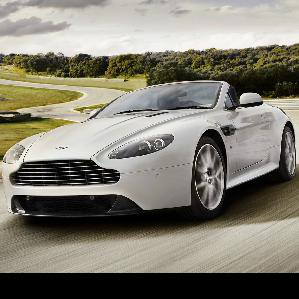

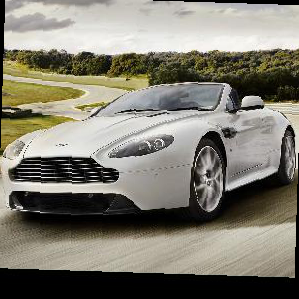

validation data (should not change):


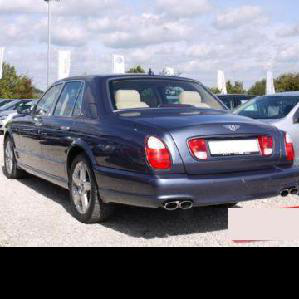

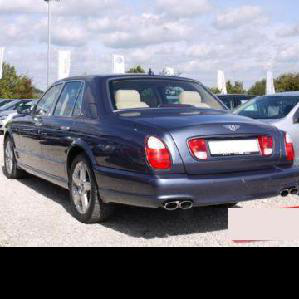

In [7]:
# example of data augmentation
i = 300

print('train data:')
im = Image.open(os.path.join(pathToDataDir, 'Train', train_generator.filenames[i]))
x_im = np.array(im)
if 2 == x_im.ndim: x_im = x_im.reshape((edge, edge, 1))
x_im_t = train_datagen.random_transform(x_im, seed=np.random.choice(100,1)[0])
if 1 == x_im_t.shape[-1]: x_im_t = x_im_t.reshape(edge, edge)
im_t = Image.fromarray(x_im_t)

display(im)
display(im_t)

print('validation data (should not change):')
im = Image.open(os.path.join(pathToDataDir, 'Validation', validation_generator.filenames[i]))
x_im = np.array(im)
if 2 == x_im.ndim: x_im = x_im.reshape((edge, edge, 1))
x_im_t = validation_datagen.random_transform(x_im, seed=np.random.choice(100,1)[0])
if 1 == x_im_t.shape[-1]: x_im_t = x_im_t.reshape(edge, edge)
im_t = Image.fromarray(x_im_t)

display(im)
display(im_t)

**Try different models**

Try a basic (kind of) CNN

In [35]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, UpSampling1D, Concatenate, AveragePooling1D, Flatten, Lambda, BatchNormalization, TimeDistributed, Permute, Reshape
from keras.regularizers import l1, l2, l1_l2
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import unit_norm
from keras.callbacks import EarlyStopping


def scaleConvNet1_image(edge, nbClass, nScale, filters):
    '''
    Inputs
    ------
    edge : int
        edge of the square images.
    nbClass : int
        number of outputs in final layer.
    '''
    
    # potentially inputable quantities...
    kernel_size = 2**4  # medium-sized coverage
    strides = 2       # should be enough to keep ~ translation invariance (no interval left uncovered)
    l1Reg = 0.00      # to be tested...
    # multDense = 1     # used for the final MLP    

    #--- design   
    In = Input((edge,edge,1))
    Scale = []
    
    L = In
    for i in range(nScale):
        # convolution part (may use more fancy filters later)
        Conv = Conv2D(filters=filters,
                      kernel_size=kernel_size,
                      strides=strides,
#                       padding='same',
#                       activation='relu',
                      activation='tanh',
                      use_bias=False)(L)
#         Conv = AveragePooling2D(pool_size=int(Conv.shape[1]))(Conv)
        Conv = MaxPooling2D(pool_size=int(Conv.shape[1]))(Conv)
        Conv = Flatten()(Conv)
        Scale.append(Conv)
        # subsampling part
        L = AveragePooling2D(pool_size=2)(L)
    
    Out = Concatenate(axis=-1)(Scale) # note: does not work if len(Out)==1
    
    # Out = Dense(multDense*(nScale*filters),activation='relu')(Out)
    # Out = Dense(multDense*(nScale*filters),activation='relu')(Out)
    
    Out = Dense(nbClass,
                activation='softmax',
                kernel_regularizer=l1(l1Reg))(Out)
    
    model = Model(inputs=[In],outputs=[Out])
            
    #--- compilation
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', # IAH: change the loss later if possible
                  metrics=['categorical_accuracy'])

    #--- return
    model.summary()
    return model    


nScale = 4
model = scaleConvNet1_image(edge, 196,
                            nScale,
                            int(196*10/nScale), # ensures ~10 times the nb of classes
                            )


# compile

model.compile(loss=loss,
              optimizer=optim,
              metrics=metric)

# train

model_history = model.fit_generator(train_generator,
                                    epochs=epochs,
                                    steps_per_epoch=int(train_generator.n/train_generator.batch_size), # as advised in docstring
                                    validation_data=validation_generator,
                                    validation_steps=int(validation_generator.n/validation_generator.batch_size), # as advised in docstring
                                    callbacks=[earlystop,checkpoint,reducelr])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
average_pooling2d_128 (AverageP (None, 64, 64, 1)    0           input_22[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_129 (AverageP (None, 32, 32, 1)    0           average_pooling2d_128[0][0]      
__________________________________________________________________________________________________
average_pooling2d_130 (AverageP (None, 16, 16, 1)    0           average_pooling2d_129[0][0]      
__________________________________________________________________________________________________
conv2d_68 

In [ ]:
#------ results
# ...
# Epoch 00010: val_acc did not improve
# 254/254 [==============================] - 300s 1s/step
# - loss: 4.6750 - acc: 0.0640 - val_loss: 5.1459 - val_acc: 0.0392

Now try transfer learning.

Try [MobileNet](https://keras.io/applications/#mobilenet):

In [17]:
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

In [29]:
# create model structure, from a base model

# create the base pre-trained model
base_model = MobileNet(input_shape=train_generator.image_shape,
                       weights='imagenet',
                       include_top=False,
                       alpha=1.0,
                       depth_multiplier=1,
                       dropout=0.001)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a top-level classifier (may have multiple layers)
x = Dense(2*train_generator.num_classes, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# total model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 64, 64, 32)        0         
__________

In [30]:
# train only the top layers

iLayerTrain = len(model.layers)-2

for i,layer in enumerate(model.layers):
    if i < iLayerTrain:
        layer.trainable = False

model.summary()
        
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss=loss,
              optimizer=optim,
              metrics=metric)

# train
model_history = model.fit_generator(train_generator,
                                    epochs=epochs,
                                    steps_per_epoch=int(train_generator.n/train_generator.batch_size), # as advised in docstring
                                    validation_data=validation_generator,
                                    validation_steps=int(validation_generator.n/validation_generator.batch_size), # as advised in docstring
                                    callbacks=[earlystop,checkpoint,reducelr])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 64, 64, 32)        0         
__________

Epoch 1/10
253/254 [============================>.] - ETA: 0s - loss: 5.0756 - acc: 0.0257
Epoch 00001: val_acc did not improve
254/254 [==============================] - 159s 627ms/step - loss: 5.0733 - acc: 0.0258 - val_loss: 4.8468 - val_acc: 0.0374
Epoch 2/10
253/254 [============================>.] - ETA: 0s - loss: 4.0971 - acc: 0.1157
Epoch 00002: val_acc improved from 0.05637 to 0.06250, saving model to /Users/arthur/Documents/GitHub/EIG3_IAFlash/IAFlash/Intelligence/model_v0.hdf5
254/254 [==============================] - 158s 622ms/step - loss: 4.0949 - acc: 0.1165 - val_loss: 4.4317 - val_acc: 0.0625
Epoch 3/10
253/254 [============================>.] - ETA: 0s - loss: 3.5197 - acc: 0.2039
Epoch 00003: val_acc improved from 0.06250 to 0.07292, saving model to /Users/arthur/Documents/GitHub/EIG3_IAFlash/IAFlash/Intelligence/model_v0.hdf5
254/254 [==============================] - 161s 633ms/step - loss: 3.5197 - acc: 0.2042 - val_loss: 4.5659 - val_acc: 0.0729
Epoch 4/10
253/

In [ ]:
#-- results
# ...
# Epoch 00010: val_acc did not improve
# 254/254 [==============================] - 157s 619ms/step
# - loss: 2.1789 - acc: 0.4485 - val_loss: 4.8961 - val_acc: 0.1213

(If needed:) we could try to train once again, but more top layers...

In [ ]:
# iLayerTrain = len(model.layers)-10

# for i,layer in enumerate(model.layers):
#     if i < iLayerTrain:
#         layer.trainable = False

# model.summary()
        
# # compile the model (should be done *after* setting layers to non-trainable)
# model.compile(loss=loss,
#               optimizer=optim,
#               metrics=metric)

# # train
# model_history = model.fit_generator(train_generator,
#                                     epochs=epochs,
#                                     steps_per_epoch=int(train_generator.n/train_generator.batch_size), # as advised in docstring
#                                     validation_data=validation_generator,
#                                     validation_steps=int(validation_generator.n/validation_generator.batch_size), # as advised in docstring
#                                     callbacks=[earlystop,checkpoint,reducelr])

Try [`VGG`](https://keras.io/applications/#vgg16) as a feature extractor for a subsequent linear classifier.

In [125]:
# create model structure, from a base model

base_model = VGG16(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalMaxPooling2D()(x)

model = Model(inputs=base_model.input, outputs=x)

model.summary()


features_train = model.predict_generator(train_generator,
                                         steps=len(train_generator),
                                         verbose=1)

features_valid = model.predict_generator(validation_generator,
                                         steps=len(validation_generator),
                                         verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [138]:
tic = time.time()

for C in (.001, .01, .1, 1, 10, 100):
    print('\nC: {}'.format(C))
    
    clf = LinearSVC(penalty='l2',
                    loss='squared_hinge',
                    dual=True,
                    tol=0.0001,
                    C=C,
                    multi_class='ovr',
                    fit_intercept=True,
                    intercept_scaling=1,
                    class_weight=None,
                    verbose=0,
                    random_state=None,
                    max_iter=1000)
    
    clf.fit(features_train, train_generator.classes)

    train_pred = clf.predict(features_train)
    val_pred = clf.predict(features_valid)

    print('  accuracy train: {}'.format(np.round(np.mean(train_pred == train_generator.classes),2)))
    print('  accuracy validation: {}'.format(np.round(np.mean(val_pred == validation_generator.classes),2)))

print('done: took {}s'.format(time.time()-tic))


C: 0.001
  accuracy train: 0.63
  accuracy validation: 0.0

C: 0.01
  accuracy train: 0.83
  accuracy validation: 0.0

C: 0.1
  accuracy train: 0.99
  accuracy validation: 0.01

C: 1
  accuracy train: 1.0
  accuracy validation: 0.01

C: 10
  accuracy train: 1.0
  accuracy validation: 0.01

C: 100
  accuracy train: 1.0
  accuracy validation: 0.0
done: took 674.152193069458s


In [ ]:
#----- results
# ...
# C: 0.001
#   accuracy train: 0.63
#   accuracy validation: 0.0

# C: 0.01
#   accuracy train: 0.83
#   accuracy validation: 0.0

# C: 0.1
#   accuracy train: 0.99
#   accuracy validation: 0.01

# C: 1
#   accuracy train: 1.0
#   accuracy validation: 0.01

# C: 10
#   accuracy train: 1.0
#   accuracy validation: 0.01

# C: 100
#   accuracy train: 1.0
#   accuracy validation: 0.0

**Some performance assessments**

In [81]:
assess_generator = validation_generator
# assess_generator = test_generator # only in the end :)

assess_model = model

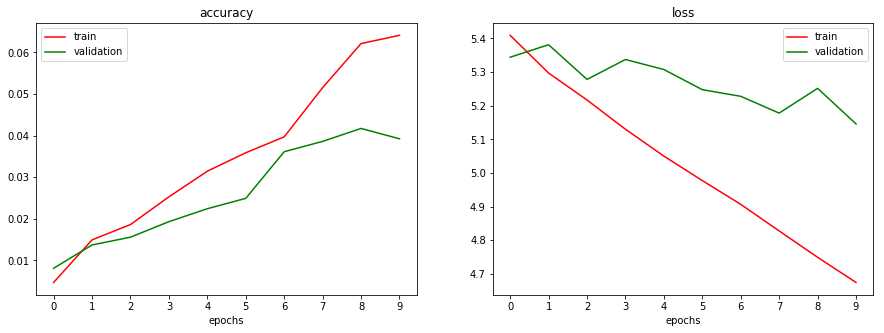

In [37]:
# plot the learning performance for naural nets

f = plt.figure(figsize=(15,5))

ax = f.add_subplot(1,2,1)
ax.plot(model_history.history['acc'], 'r')
ax.plot(model_history.history['val_acc'], 'g')
ax.set_xticks(np.arange(0, epochs, 1))
ax.set_xlabel('epochs')
# ax.set_ylabel('accuracy')
ax.set_title('accuracy')
ax.legend(['train','validation'])
 
ax = f.add_subplot(1,2,2)
ax.plot(model_history.history['loss'], 'r')
ax.plot(model_history.history['val_loss'], 'g')
ax.set_xticks(np.arange(0, epochs, 1))
ax.set_xlabel('epochs')
# ax.set_ylabel('loss')
ax.set_title('loss')
ax.legend(['train','validation'])

plt.show()

<img src='scaleNet_learning.png' width="800">

In [83]:
# predictions

score = assess_model.predict_generator(assess_generator,
                                       steps=len(assess_generator),
                                       max_queue_size=10,
                                       workers=1,
                                       use_multiprocessing=False,
                                       verbose=1)
predicted = np.argmax(score, axis=1)

  10/1561 [..............................] - ETA: 19:20

KeyboardInterrupt: 


confusion matrix


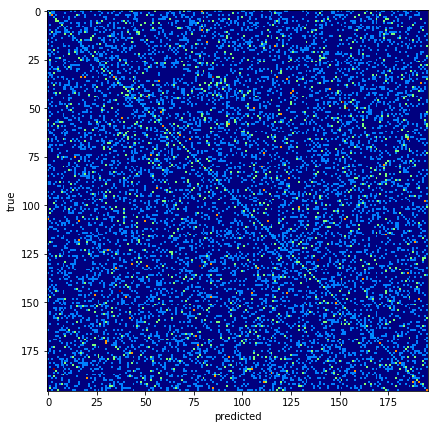


classification report


NameError: name 'predicted' is not defined

In [96]:
# ranked predictions
i,K = 242,5

true_i = assess_generator.classes[i]
score_i = score[i,:]
argsort_i = np.argsort(score_i)[::-1]
print('\ntop {} predictions for image {} with true class {}:'.format(K, i, true_i))
for k in range(K):
    print('   {} ({})'.format(argsort_i[k],score_i[argsort_i[k]]))
print('correct class at rank: {} out of {}'.format(1+np.where(argsort_i==true_i)[0][0], assess_generator.num_classes))

# accuracy
acc = np.mean(assess_generator.classes == predicted)
print('\nmean accuracy: {}'.format(acc))

# confusion matrix
print('\nconfusion matrix')
conf = confusion_matrix(assess_generator.classes, predicted)
f = plt.figure(figsize=(7,7))
ax = f.add_subplot(1,1,1)
ax.imshow(conf, cmap=plt.cm.jet, interpolation='nearest')
ax.set_xlabel('predicted')
ax.set_ylabel('true')
plt.show()

print('\nclassification report')
report = classification_report(assess_generator.classes,
                               predicted,
                               target_names=np.sort(list(assess_generator.class_indices.keys())).tolist())
# print(report)
# print(classification_report_todf(report))

In [ ]:
#----- exple results
#
# top 5 predictions for image 242 with true class 25:
#    4 (0.03445896506309509)
#    7 (0.033822767436504364)
#    13 (0.032161831855773926)
#    133 (0.023463722318410873)
#    57 (0.023263944312930107)
# correct class at rank: 21 out of 196

# mean accuracy: 0.00311332503113325

<img src='exple_conf.png' width="300">

### Save material for later use in API

In [62]:
# data preprocessors
pickle.dump(test_datagen, open(os.path.join(pathToIntellDir, 'datagen.pkl'),'wb'))
pickle.dump(assess_generator.class_indices, open(os.path.join(pathToIntellDir, 'classesDict.pkl'),'wb'))

# model
assess_model.save(os.path.join(pathToIntellDir, 'model.h5'))